In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import calendar
import matplotlib.pyplot as plt
import yfinance as yf
import re
from nltk.tokenize import word_tokenize

from collections import Counter
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score

import torch
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
import torch.optim as optim
from torch.optim.lr_scheduler import ExponentialLR
import torch.nn as nn
from torchmetrics.classification import BinaryConfusionMatrix

from transformers import AutoTokenizer
sns.set_theme(style="whitegrid")

C:\Users\satvi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Exploratory Data Analysis

### News Datasets

The three news datasets are obtained through [Kaggle](https://www.kaggle.com/datasets/notlucasp/financial-news-headlines/data). The author mentioned these data are scraped from CNBC, the Guardian, and Reuters official websites, the headlines in these datasets reflects the overview of the U.S. economy and stock market every day for the past year to 2 years.

The Timeframes of data:

  - Data scraped from CNBC contains the headlines, last updated date, and the preview text of articles from the end of `December 2017` to `July 19th, 2020`.
  - Data scraped from the Guardian Business contains the headlines and last updated date of articles from the end of `December 2017` to `July 19th, 2020` since the Guardian Business does not offer preview text.
  - Data scraped from Reuters contains the headlines, last updated date, and the preview text of articles from the end of `March 2018` to `July 19th, 2020`.

In [2]:
cnbc_data = pd.read_csv('dataset/cnbc_headlines.csv')

# There is ,, empty lines in CNBC, drop them
cnbc_data.dropna(subset=['Time'],inplace=True)

guardian_data = pd.read_csv('dataset/guardian_headlines.csv')
reuters_data = pd.read_csv('dataset/reuters_headlines.csv')

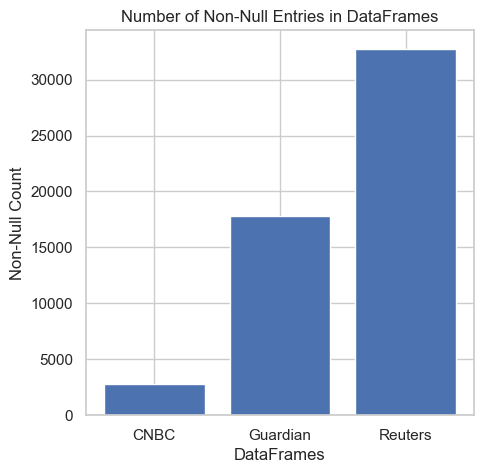

In [3]:
dfs = [cnbc_data, guardian_data, reuters_data]
df_names = ['CNBC', 'Guardian', 'Reuters']

non_null_counts = [df.dropna().shape[0] for df in dfs]

plt.figure(figsize=(5, 5))
plt.bar(df_names, non_null_counts)
plt.title("Number of Non-Null Entries in DataFrames")
plt.xlabel("DataFrames")
plt.ylabel("Non-Null Count")
plt.show()

We can see here that all of the news datasets have varying numbers of data points ranging from 2800 to 32700. This will not be a problem for us since our question focuses on the impact of news headlines in general on the S&P 500, so all of this data will be combined in to a larger dataset ordered by the date of the headline. We can also see there is null data within the CNBC dataset which will be removed. 

#### Headline Length


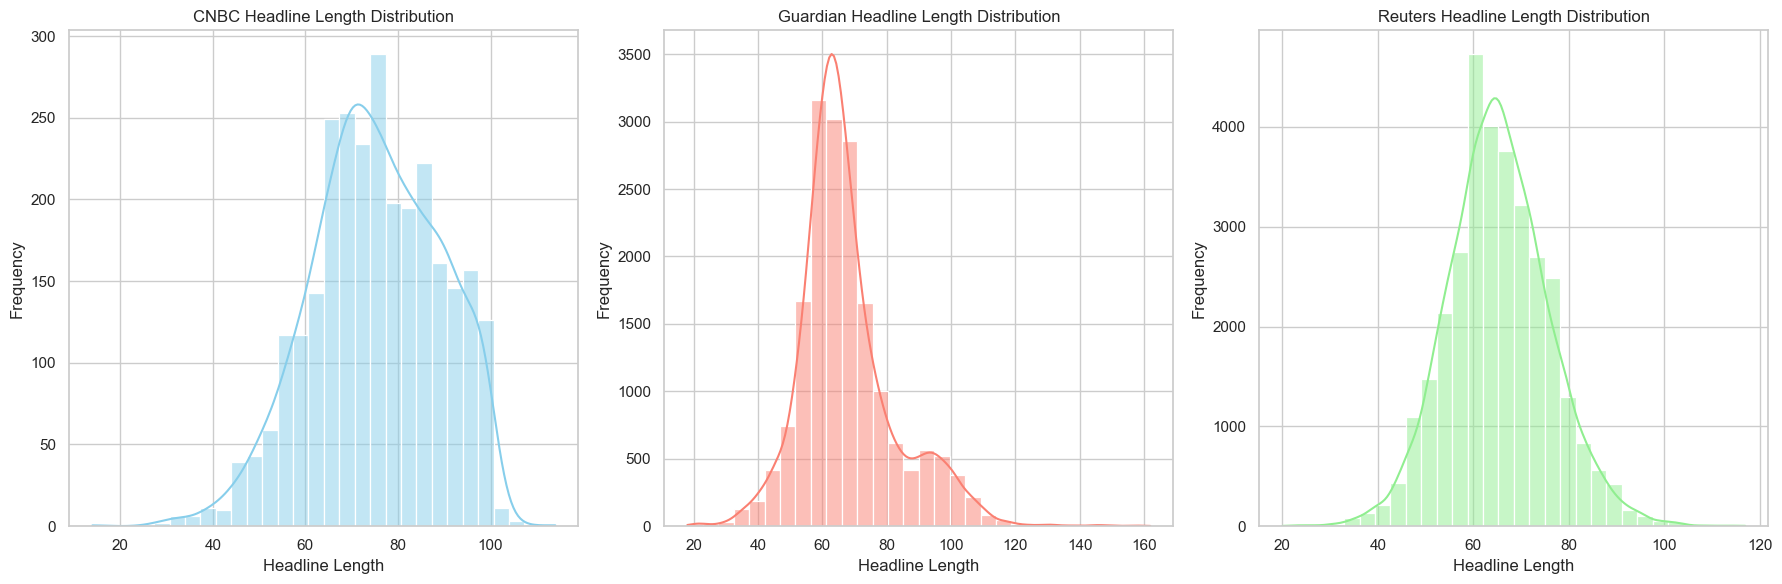

In [4]:
fig, ax = plt.subplots(1, 3, figsize=(18, 6))

# CNBC dataset
sns.histplot(cnbc_data['Headlines'].fillna("").apply(len), bins=30, kde=True, ax=ax[0], color="skyblue")
ax[0].set_title("CNBC Headline Length Distribution")
ax[0].set_xlabel("Headline Length")
ax[0].set_ylabel("Frequency")

# Guardian dataset
sns.histplot(guardian_data['Headlines'].fillna("").apply(len), bins=30, kde=True, ax=ax[1], color="salmon")
ax[1].set_title("Guardian Headline Length Distribution")
ax[1].set_xlabel("Headline Length")
ax[1].set_ylabel("Frequency")

# Reuters dataset
sns.histplot(reuters_data['Headlines'].fillna("").apply(len), bins=30, kde=True, ax=ax[2], color="lightgreen")
ax[2].set_title("Reuters Headline Length Distribution")
ax[2].set_xlabel("Headline Length")
ax[2].set_ylabel("Frequency")

plt.tight_layout()
plt.show()


These histograms display the number of headlines given a specific length. Disregarding the bar at length of 0 in the CNBC graph due to the null data, headlines from all three stations seem to center around 60-70 words with the max being ~100 for CNBC and Reuters, and ~120 for the Guardian.

#### Headline Distribution

To find out the distribution of headlines throughout the time frame, we generated a graph with headlines colored differently in each month of the year.

In [5]:
# Extra cleaning for CNBC
cnbc_data['Time'] = (
    cnbc_data['Time']
    .str.replace(r"ET", "", regex=True)  
    .str.strip() 
    .str.replace(r"\s+", " ", regex=True)
)

In [6]:
cnbc_data['Time'] = pd.to_datetime(
    cnbc_data['Time'], format="mixed", errors='coerce'
)

# For GUARDIAN
guardian_data['Time'] = pd.to_datetime(
    guardian_data['Time'], format='%d-%b-%y', errors='coerce'
)

# For REUTERS
reuters_data['Time'] = pd.to_datetime(
    reuters_data['Time'], format='%b %d %Y', errors='coerce'
)

# Adding additional columns for time analysis
for df in [cnbc_data, guardian_data, reuters_data]:
    # Extract date parts for time-based analysis
    df['Year'] = df['Time'].dt.year
    df['Month'] = df['Time'].dt.month

# Frequency of headlines by year and month for each dataset
cnbc_yearly_counts = cnbc_data.groupby(['Year', 'Month']).size().unstack(fill_value=0)
guardian_yearly_counts = guardian_data.groupby(['Year', 'Month']).size().unstack(fill_value=0)
reuters_yearly_counts = reuters_data.groupby(['Year', 'Month']).size().unstack(fill_value=0)

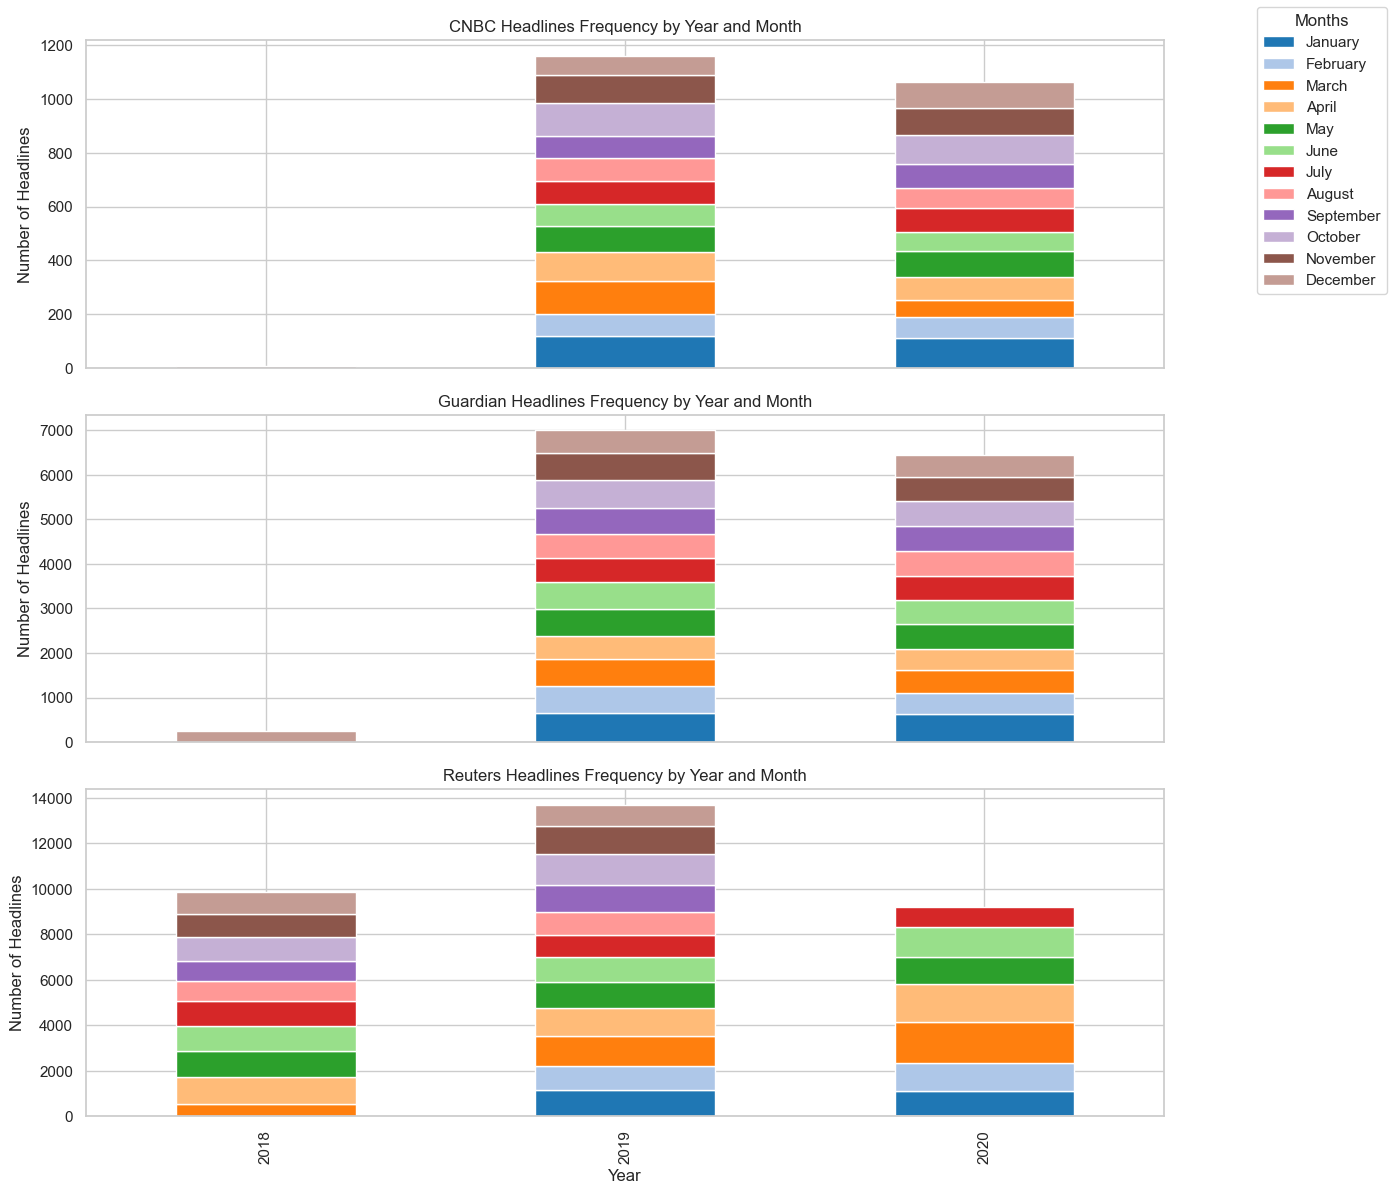

In [7]:
fig, ax = plt.subplots(3, 1, figsize=(14, 12), sharex=True)

# Set a colormap to represent months consistently
month_colors = plt.colormaps["tab20"]

# CNBC dataset with month colors
cnbc_yearly_counts.plot(kind="bar", stacked=True, ax=ax[0], color=[month_colors(i) for i in range(12)], legend=False)
ax[0].set_title("CNBC Headlines Frequency by Year and Month")
ax[0].set_ylabel("Number of Headlines")

# Guardian dataset with month colors
guardian_yearly_counts.plot(kind="bar", stacked=True, ax=ax[1], color=[month_colors(i) for i in range(12)], legend=False)
ax[1].set_title("Guardian Headlines Frequency by Year and Month")
ax[1].set_ylabel("Number of Headlines")

# Reuters dataset with month colors
reuters_yearly_counts.plot(kind="bar", stacked=True, ax=ax[2], color=[month_colors(i) for i in range(12)], legend=False)
ax[2].set_title("Reuters Headlines Frequency by Year and Month")
ax[2].set_ylabel("Number of Headlines")
ax[2].set_xlabel("Year")

# Adding a single legend for the months
month_names = [calendar.month_name[i] for i in range(1, 13)]
fig.legend(month_names, loc="upper right", title="Months")
plt.tight_layout(rect=[0, 0, 0.85, 1])  # Adjust layout to fit the legend
plt.show()

These graphs depict the number of headlines per month per year. With this, we can see that the earlier months of the year seem to have a higher concentration of headlines. 

In [8]:
for df in [cnbc_data, guardian_data, reuters_data]:
    df.drop(columns=['Year','Month'],inplace=True)

#### Word Frequency

A short analysis on word frequency. We used the stopword dictionary in `nltk` to help filtering out words like `a` and `the`.

In [9]:
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\satvi\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


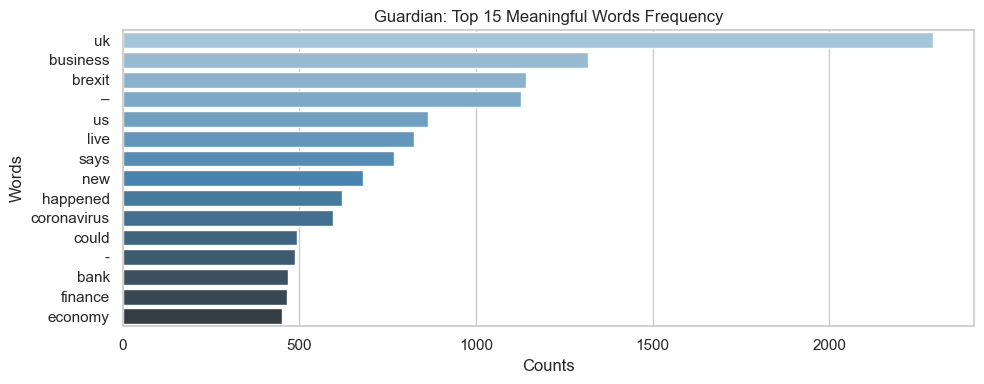

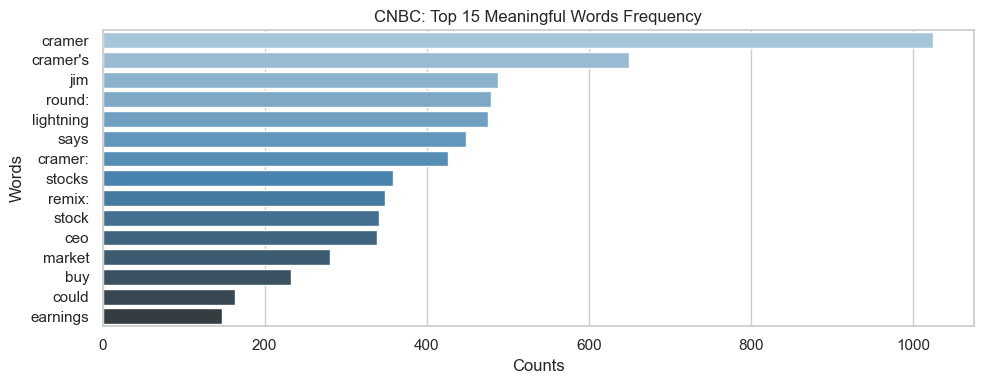

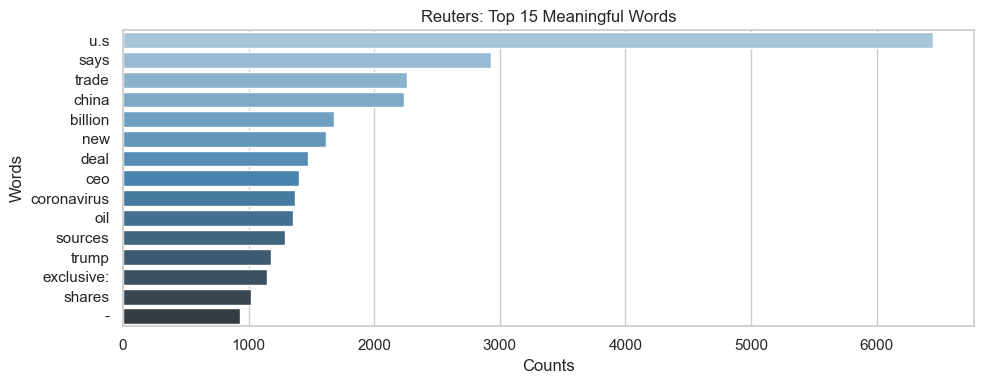

In [10]:
# Function to clean and process headlines for meaningful word frequencies
def process_and_plot(data, title, start=0, end=15, stopwords=None):
    stopwords = stop_words
    
    combined_string = ' '.join(data['Headlines'])  # Combine all headlines
    word_list = combined_string.split()  # Split into words
    word_list = [word.lower().strip(",.!?()[]") for word in word_list if word.lower() not in stopwords]
    
    # Calculate word frequencies
    word_count = Counter(word_list)
    
    # Sort words by frequency
    sorted_words = word_count.most_common()  # Sort by frequency
    top_words = sorted_words[start:end]  # Select words from the specified range
    
    # Create lists of words and their counts
    words = [word for word, count in top_words]
    counts = [count for word, count in top_words]
    
    # Plot the bar chart
    plt.figure(figsize=(10, 4))
    sns.barplot(x=counts, y=words,hue=words, palette="Blues_d", orient="h")
    plt.xlabel('Counts')
    plt.ylabel('Words')
    plt.title(title)
    plt.tight_layout()
    plt.show()

# Plot for each dataset excluding common stopwords
process_and_plot(guardian_data, 'Guardian: Top 15 Meaningful Words Frequency')
process_and_plot(cnbc_data, 'CNBC: Top 15 Meaningful Words Frequency')
process_and_plot(reuters_data, 'Reuters: Top 15 Meaningful Words')

Most of the words are meaningful, but who is `cramer` in the CNBC dataset? Turns out [Jim Cramer](https://en.wikipedia.org/wiki/Jim_Cramer) is the host of various financial programs in CNBC. We will prune him out from the CNBC dataset later.

### S&P 500 Dataset

In [11]:
ticker = "^GSPC"
start_date = "2017-12-01"
end_date = "2020-07-31"

data = yf.download(ticker, start=start_date, end=end_date, interval="1d")
data_hlcv = data[['High', 'Low', 'Close', 'Volume']]

[*********************100%***********************]  1 of 1 completed


#### Statistical Analysis

In [12]:
data_hlcv.describe()

Price,High,Low,Close,Volume
Ticker,^GSPC,^GSPC,^GSPC,^GSPC
count,669.000000,669.000000,669.000000,6.690000e+02
mean,2883.568308,2849.033738,2867.277964,3.965081e+09
std,198.117998,206.057495,202.285824,1.154337e+09
min,2300.729980,2191.860107,2237.399902,1.296530e+09
25%,2739.189941,2709.540039,2724.439941,3.300220e+09
50%,2856.669922,2825.389893,2843.489990,3.635780e+09
75%,2999.149902,2970.090088,2984.870117,4.156640e+09
max,3393.520020,3378.830078,3386.149902,9.053950e+09


The S&P 500 dataset from December 1, 2017, to July 31, 2020, contains **669** daily records with columns for `High`, `Low`, `Close`, and `Volume`, with **no missing values**. The average 'High', 'Low', and 'Close' prices are around 2883, 2849, and 2867, respectively, with standard deviations near 200 points, indicating moderate volatility. The 'Volume' data, averaging 3.97 billion shares, shows considerable variability, ranging from 1.3 billion to 9.05 billion, reflecting spikes in trading activity during certain market events.

To prepare for analysis, normalization or standardization may be beneficial to handle the scale differences, particularly between price and volume data. This initial overview confirms a relatively stable daily distribution, setting up further analysis on trends, volatility, and potential event impacts on S&P 500 performance.

#### Close Price over Time

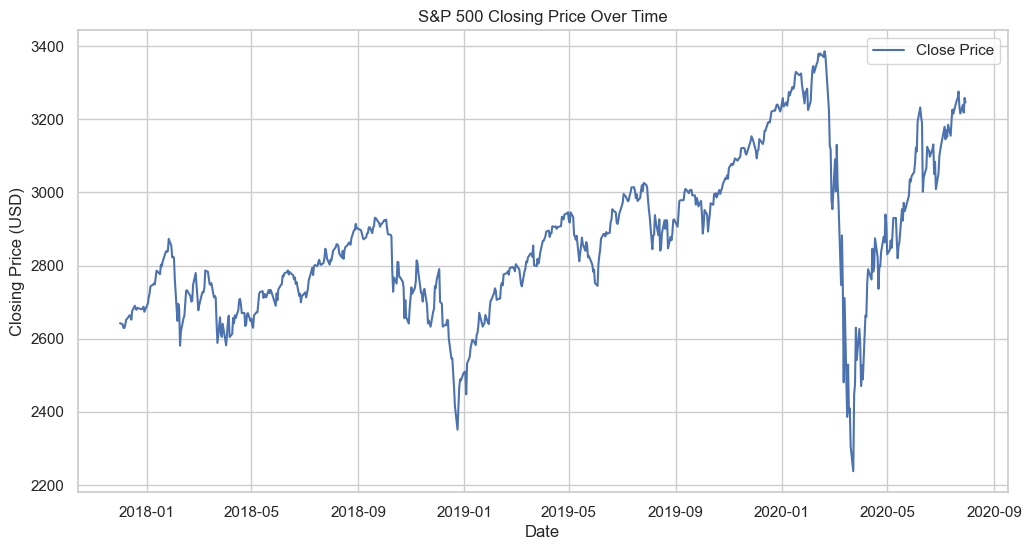

In [13]:
plt.figure(figsize=(12, 6))
sns.lineplot(x=data_hlcv.index, y=data_hlcv['Close'].squeeze(), color="#4c72b0", label="Close Price")
plt.title("S&P 500 Closing Price Over Time")
plt.xlabel("Date")
plt.ylabel("Closing Price (USD)")
plt.legend()
plt.show()

This is the stock price of the S&P 500 over min and max dates covered by the news headlines. Some noticeable features that are included in this graph is the large dip during early 2020 caused by covid. This will have an interesting impact on our model since the news did play a big role in the scare factor for COVID-19, but the fact that it was caused by a global epidemic may skew the embeddings of other words.  

## Data Preprocessing

Clean out `NaT` values in `Time` column of three datasets.

In [14]:
guardian_data.dropna(subset=['Time'], inplace=True)
cnbc_data.dropna(subset=['Time'], inplace=True)
reuters_data.dropna(subset=['Time'], inplace=True)

### Cleaning Text

Here we did our first cleaning by converting all characters to lower case, and remove extra spaces, quotation marks and other unwanted ones. We are also removing `Jim` `Cramer`, as well as his show `Mad Money` from the CNBC dataset.

In [15]:
def clean_headlines(text):
    # Convert text to lowercase
    text = text.lower()
    # Remove special characters except hyphens and spaces
    text = re.sub(r"[^\w\s\-]", "", text)
    words = word_tokenize(text)

    cleaned_text = " ".join(words)
    return cleaned_text


guardian_data['Headlines'] = guardian_data['Headlines'].apply(clean_headlines)

cnbc_data['Headlines'] = cnbc_data['Headlines'].apply(clean_headlines)
cnbc_data['Description'] = cnbc_data['Description'].apply(clean_headlines)

reuters_data['Headlines'] = reuters_data['Headlines'].apply(clean_headlines)
reuters_data['Description'] = reuters_data['Description'].apply(clean_headlines)

def remove_jim(text):
    words_to_remove = ['jim', 'cramer', 'mad money']

    pattern = r'\b(' + '|'.join(words_to_remove) + r')\b'
    cleaned = re.sub(pattern, '', text, flags=re.IGNORECASE)

    cleaned = re.sub(r'\s+', ' ', cleaned).strip()
    return cleaned

cnbc_data['Headlines'] = cnbc_data['Headlines'].apply(remove_jim)
cnbc_data['Description'] = cnbc_data['Description'].apply(remove_jim)

cnbc_data.head()

,Headlines,Time,Description
0,a better way to invest in the covid-19 vaccine...,2020-07-17 19:51:00,host recommended buying four companies that ar...
1,cramers lightning round i would own teradyne,2020-07-17 19:33:00,host rings the lightning round bell which mean...
3,cramers week ahead big week for earnings even ...,2020-07-17 19:25:00,well pay more for the earnings of the non-covi...
4,iq capital ceo keith bliss says tech and healt...,2020-07-17 16:24:00,keith bliss iq capital ceo joins closing bell ...
5,wall street delivered the kind of pullback ive...,2020-07-16 19:36:00,look for the stocks of high-quality companies ...


### Add Prediction Target

Since our goal is to relate news outlets with S&P500, part of our project will be focusing on the trend prediction of future S&P 500 price change. Which we created a binary column `trend_up` which will be `True` if the price current trading date is lower than tomorrow's.

In [16]:
stock_data = data_hlcv.reset_index()[['Date', 'Close']]

# Flatten the column headers if they are multi-level
stock_data.columns = stock_data.columns.map(lambda x: x[1] if isinstance(x, tuple) else x)
stock_data.rename(columns={stock_data.columns[0]: 'Date', stock_data.columns[1]: 'Close'}, inplace=True)

stock_data['trend_up'] = stock_data['Close'].shift(-1) > stock_data['Close']
stock_data.head()

,Date,Close,trend_up
0,2017-12-01,2642.219971,False
1,2017-12-04,2639.439941,False
2,2017-12-05,2629.570068,False
3,2017-12-06,2629.270020,True
4,2017-12-07,2636.979980,True


We also want to make sure that the proportion `True` and `False` are balanced.

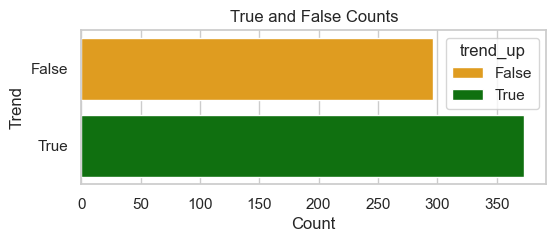

In [17]:
trend_counts = stock_data['trend_up'].value_counts()
colors = ["orange" if trend == False else "green" for trend in trend_counts.index]

plt.figure(figsize=(6, 2))
sns.barplot(
    y=trend_counts.index,
    hue=trend_counts.index,
    x=trend_counts.values,
    palette=["orange","green"],
    orient='h'
)
plt.title("True and False Counts")
plt.ylabel("Trend")
plt.xlabel("Count")
plt.yticks(ticks=[0, 1], labels=["False", "True"]) 
plt.show()

### Set Time Granularity

Though some of the datasets has timestamp with minute-wise precisions, we only want to research on a daily basis.

In [18]:
guardian_data['Date'] = pd.to_datetime(guardian_data['Time']).dt.date
cnbc_data['Date'] = pd.to_datetime(cnbc_data['Time']).dt.date
reuters_data['Date'] = pd.to_datetime(reuters_data['Time']).dt.date

guardian_data.drop(columns=['Time'],inplace=True)
cnbc_data.drop(columns=['Time'],inplace=True)
reuters_data.drop(columns=['Time'],inplace=True)

stock_data['Date'] = pd.to_datetime(stock_data['Date']).dt.date

### Concatenate 3 New Datasets

For our first model, we will ignore temporal relationship by treating every news as an independent datapoint. We merged all datasets into one, along with the prediction target.

In [19]:
# Concatenate datasets with stock data
cnbc_merged = pd.merge(cnbc_data, stock_data, on='Date', how='inner')
cnbc_merged['Source'] = 'CNBC'
guardian_merged = pd.merge(guardian_data, stock_data, on='Date', how='inner')
guardian_merged['Source'] = 'Guardian'
reuters_merged = pd.merge(reuters_data, stock_data, on='Date', how='inner')
reuters_merged['Source'] = 'Reuters'

# Combine all datasets into one
first_model_data = pd.concat([cnbc_merged, guardian_merged, reuters_merged])

first_model_data.to_csv("dataset/first_model_data.csv", index=False) 
first_model_data.head()

,Headlines,Description,Date,Close,trend_up,Source
0,a better way to invest in the covid-19 vaccine...,host recommended buying four companies that ar...,2020-07-17,3224.729980,True,CNBC
1,cramers lightning round i would own teradyne,host rings the lightning round bell which mean...,2020-07-17,3224.729980,True,CNBC
2,cramers week ahead big week for earnings even ...,well pay more for the earnings of the non-covi...,2020-07-17,3224.729980,True,CNBC
3,iq capital ceo keith bliss says tech and healt...,keith bliss iq capital ceo joins closing bell ...,2020-07-17,3224.729980,True,CNBC
4,wall street delivered the kind of pullback ive...,look for the stocks of high-quality companies ...,2020-07-16,3215.570068,True,CNBC


## Base Models

### Classification Models

We are using logistic regression with TF-IDF features as our base model.

#### Individual Headline Model

For this model, we are treating every news are individual data points. This is guarantee to fail because there is way to little information contained in a single news title, and there will be too much noise.

In [20]:
data = first_model_data[['Headlines', 'trend_up']].copy()

vectorizer = TfidfVectorizer(max_features=300) 
X = vectorizer.fit_transform(data['Headlines']).toarray()
y = data['trend_up']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


model = LogisticRegression(random_state=42, max_iter=1500)
model.fit(X_train, y_train)

y_pred_test = model.predict(X_test)
y_pred_train = model.predict(X_train)

train_accuracy = accuracy_score(y_train, y_pred_train)
test_accuracy = accuracy_score(y_test, y_pred_test)

# Display results
print("Test Accuracy:", test_accuracy)
print("Train Accuracy:", train_accuracy)
print("Report on test dataset:")
pd.DataFrame(classification_report(y_test, y_pred_test, output_dict=True)).transpose()

Test Accuracy: 0.5475510419972496
Train Accuracy: 0.5670951020839945
Report on test dataset:


,precision,recall,f1-score,support
False,0.465389,0.103751,0.169676,4212.000000
True,0.556613,0.904217,0.689059,5241.000000
accuracy,0.547551,0.547551,0.547551,0.547551
macro avg,0.511001,0.503984,0.429367,9453.000000
weighted avg,0.515966,0.547551,0.457636,9453.000000


In [21]:
data.to_csv("single_dataset.csv",index=False)

#### Joint Headline Model

By joining all headlines of the same day in to one sentence, we hope that TF-IDF could capture more information than our previous model.

In [22]:
grouped_dataset = first_model_data.groupby('Date').agg(
    Headlines=('Headlines', ' '.join), 
    trend_up=('trend_up', 'first') 
).reset_index()

grouped_dataset.head()

,Date,Headlines,trend_up
0,2017-12-18,france saves marquis de sades 120 days of sodo...,False
1,2017-12-19,house prices to fall in london and south-east ...,False
2,2017-12-20,hedge funds fail to stop billion-dollar brain ...,True
3,2017-12-21,guardian brexit watch brexit helped push down ...,False
4,2017-12-22,says owning too many stocks and too little cas...,False


In [23]:
data = grouped_dataset[['Headlines', 'trend_up']].copy()

vectorizer = TfidfVectorizer(max_features=200)
X = vectorizer.fit_transform(data['Headlines']).toarray()
y = data['trend_up']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=3)


model = LogisticRegression(random_state=3, max_iter=1500)
model.fit(X_train, y_train)

y_pred_test = model.predict(X_test)
y_pred_train = model.predict(X_train)

train_accuracy = accuracy_score(y_train, y_pred_train)
test_accuracy = accuracy_score(y_test, y_pred_test)

# Display results
print("Test Accuracy:", test_accuracy)
print("Train Accuracy:", train_accuracy)
print("Report on test dataset:")
pd.DataFrame(classification_report(y_test, y_pred_test, output_dict=True)).transpose()

Test Accuracy: 0.5230769230769231
Train Accuracy: 0.6615087040618955
Report on test dataset:


,precision,recall,f1-score,support
False,0.400000,0.066667,0.114286,60.000000
True,0.533333,0.914286,0.673684,70.000000
accuracy,0.523077,0.523077,0.523077,0.523077
macro avg,0.466667,0.490476,0.393985,130.000000
weighted avg,0.471795,0.523077,0.415500,130.000000


We also experimented in the amount of features TF-IDF should have in order to have the best performance.

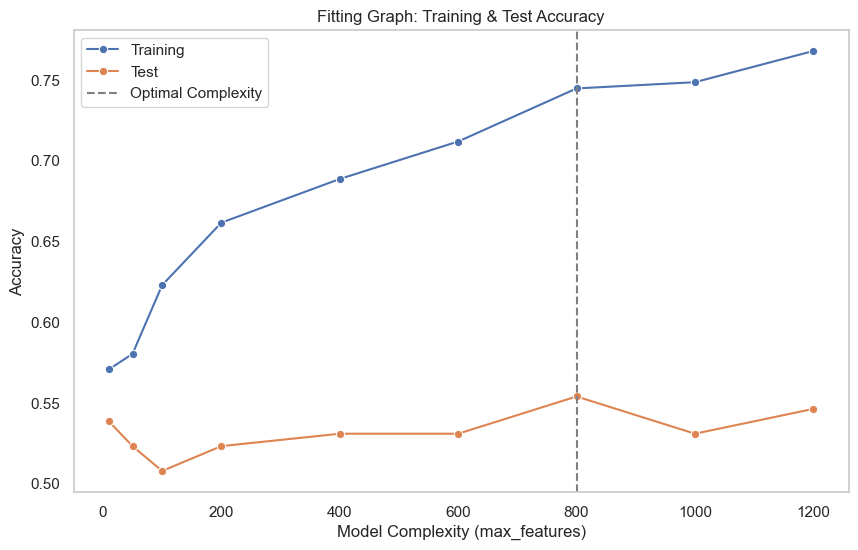

In [24]:
complexities = [10, 50, 100, 200, 400, 600, 800, 1000, 1200]

# Lists to store accuracies
train_accuracies = []
test_accuracies = []

for max_features in complexities:
    vectorizer = TfidfVectorizer(max_features=max_features)
    X = vectorizer.fit_transform(data['Headlines']).toarray()
    y = data['trend_up']
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=3)
    
    model = LogisticRegression(random_state=3, max_iter=1500)
    model.fit(X_train, y_train)
    
    train_accuracy = accuracy_score(y_train, model.predict(X_train))
    test_accuracy = accuracy_score(y_test, model.predict(X_test))
    
    train_accuracies.append(train_accuracy)
    test_accuracies.append(test_accuracy)


plot_data = pd.DataFrame({
    'Complexity': complexities * 2,
    'Accuracy': train_accuracies + test_accuracies,
    'Type': ['Training'] * len(complexities) + ['Test'] * len(complexities)
})

plt.figure(figsize=(10, 6))
sns.lineplot(data=plot_data, x='Complexity', y='Accuracy', hue='Type', marker='o')
plt.axvline(x=complexities[np.argmax(test_accuracies)], linestyle='--', color='gray', label="Optimal Complexity")
plt.title("Fitting Graph: Training & Test Accuracy")
plt.xlabel("Model Complexity (max_features)")
plt.ylabel("Accuracy")
plt.legend()
plt.grid()
plt.show()

As expected, we do not need to high complexity for TF-IDF, as increasing it will overfit our training dataset. A complexity around 800 yields the best result on the test set with accuracy about 55%.

# Transformer Model

In [25]:
data = pd.read_csv("grouped_dataset.csv")

In [26]:
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased") 

In [27]:
# Class that containerizes the dataset
class NewsDataset(Dataset):
    def __init__(self, headlines, labels, tokenizer, max_length):
        self.headlines = headlines
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.headlines)

    def __getitem__(self, idx):
        # Tokenize individual headline
        text = self.headlines[idx]
        tokens = self.tokenizer(
            text,
            padding="max_length",
            truncation=True,
            max_length=self.max_length,
            return_tensors="pt"
        )
        return tokens['input_ids'].squeeze(0), torch.tensor(self.labels[idx], dtype=torch.float)
        

In [28]:
# Create the test and train data loaders from data
def createDataLoader(train_data, test_data, tokenizer, MAX_LENGTH, BATCH_SIZE):
    train_PYdataset = NewsDataset(
        headlines=train_data['Headlines'].tolist(),
        labels=train_data['trend_up'].astype(int).tolist(),
        tokenizer=tokenizer,
        max_length=MAX_LENGTH
    )
    train_dataloader = DataLoader(
        train_PYdataset, 
        batch_size=BATCH_SIZE,
        shuffle=True,
    )


    test_PYdataset = NewsDataset(
        headlines=test_data['Headlines'].tolist(),
        labels=test_data['trend_up'].astype(int).tolist(),
        tokenizer=tokenizer,
        max_length=MAX_LENGTH
    )
    test_dataloader = DataLoader(
        test_PYdataset, 
        batch_size=BATCH_SIZE,
        shuffle=True,
    )

    return train_dataloader, test_dataloader

In [29]:
# An untrained transformer class with multiple hyperparameters
class UntrainedTransformerClassifier(nn.Module):
    def __init__(self, vocab_size, embed_dim, num_heads, num_layers, max_length, num_output, dropout = 0.2):
        super(UntrainedTransformerClassifier, self).__init__()

        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.positional_encoding = nn.Embedding(max_length,embed_dim)

        # Transformer encoder
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=embed_dim,
            nhead=num_heads,
            dim_feedforward=embed_dim * 4,
            dropout=dropout,
            batch_first=True,
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

        #
        self.linear = nn.Linear(embed_dim, num_output)
        self.dropout = nn.Dropout(dropout)

    def forward(self, input_ids):
        seq_length = input_ids.size(1)

        # Token embedding + positional encoding
        x = self.embedding(input_ids) + self.positional_encoding(torch.arange(seq_length,device=input_ids.device))

        x = self.transformer(x)

        x = self.dropout(x)
        x = x.max(dim=1)[0]
        out = self.linear(x)
        return out   


In [30]:
# Set device for torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [31]:
# Evalutation method for single class
def evaluate(model, dataloader, device):
    model.eval()
    correct = 0
    total_samples = 0

    with torch.no_grad():
        for X, Y in dataloader:
            input_ids = X.to(device)
            labels = Y.to(device)

            logits = model(input_ids)
            outputs = torch.sigmoid(logits).squeeze(1)


            preds = (outputs >= 0.5).float()
            correct += (preds == labels).sum().item()
            total_samples += labels.size(0)

    accuracy = correct / total_samples
    model.train()
    return accuracy

In [32]:
#Evaluation method for two classes
def evaluate_old(model, dataloader, device):
    model.eval()
    correct = 0
    total_samples = 0

    with torch.no_grad():  # Disable gradient computation
        for X,Y in dataloader:
            input_ids = X.to(device)  # Move to device
            labels = Y.to(device)        # Move to device


            logits = model(input_ids)
            # Calculate predictions
            _,preds = torch.max(logits.data, 1)
            correct += (preds == labels).sum().item()
            total_samples += labels.size(0)


    accuracy = correct / total_samples
    model.train()
    return accuracy

In [33]:
# Generates the fitting graph given test and train error
def generateFittingGraph(train_error, test_error, epochs):
    x = range(1,epochs+1)
    plt.plot(x, train_error, label="Train Error")
    plt.plot(x, test_error, label="Test Error")
    
    plt.xlabel("Epochs")
    plt.ylabel("Predictive Error")
    plt.title("Fitting Graph")

    plt.legend()
    plt.show()



### Base Classifier Transformer Model

In [ ]:
MAX_LENGTH = 600
BATCH_SIZE = 16
EMBED_DIM = 128
NUM_HEAD = 4
NUM_LAYER = 6
NUM_OUTPUT = 2
EPOCHS = 25
LEARNING_RATE = 1e-4

train_dataset, test_dataset = train_test_split(data, test_size=0.2, shuffle=True, random_state=42)
train_dataloader, test_dataloader = createDataLoader(train_dataset, test_dataset, tokenizer, MAX_LENGTH, BATCH_SIZE)

model = UntrainedTransformerClassifier(vocab_size=tokenizer.vocab_size, 
                                       embed_dim= EMBED_DIM, 
                                       num_heads= NUM_HEAD, 
                                       num_layers=NUM_LAYER, 
                                       max_length=MAX_LENGTH,
                                       num_output=NUM_OUTPUT).to(device)

criterion = nn.CrossEntropyLoss()


optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

train_error = []
test_error = []

for epoch in range(EPOCHS):
    for xb, yb in train_dataloader:
        yb = yb.type(torch.LongTensor)
        xb, yb = xb.to(device), yb.to(device)

        logits = model(xb)
        loss = criterion(logits, yb)
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    trainErr = evaluate_old(model, train_dataloader, device)    
    testErr = evaluate_old(model, test_dataloader, device) 

    print(f"Epoch [{epoch+1}/{EPOCHS}], Loss: {loss.item():.4f}, Train Acc: {trainErr:.4f}, Test Acc: {testErr:.4f}")

    train_error.append(1-trainErr)
    test_error.append(1-testErr)

Epoch [1/25], Loss: 1.0333, Train Acc: 0.5687, Test Acc: 0.5077
Epoch [2/25], Loss: 0.7410, Train Acc: 0.5532, Test Acc: 0.5846
Epoch [3/25], Loss: 0.8440, Train Acc: 0.6615, Test Acc: 0.5000
Epoch [4/25], Loss: 0.5991, Train Acc: 0.5532, Test Acc: 0.5846
Epoch [5/25], Loss: 0.6119, Train Acc: 0.5783, Test Acc: 0.6077
Epoch [6/25], Loss: 0.5687, Train Acc: 0.6035, Test Acc: 0.5923
Epoch [7/25], Loss: 0.5094, Train Acc: 0.5629, Test Acc: 0.5846
Epoch [8/25], Loss: 0.6541, Train Acc: 0.5977, Test Acc: 0.5846
Epoch [9/25], Loss: 0.6230, Train Acc: 0.7718, Test Acc: 0.5385
Epoch [10/25], Loss: 0.5481, Train Acc: 0.8143, Test Acc: 0.5231
Epoch [11/25], Loss: 0.5217, Train Acc: 0.8878, Test Acc: 0.4308
Epoch [12/25], Loss: 0.6465, Train Acc: 0.8781, Test Acc: 0.5385
Epoch [13/25], Loss: 0.3898, Train Acc: 0.9749, Test Acc: 0.4846
Epoch [14/25], Loss: 0.4563, Train Acc: 0.9400, Test Acc: 0.4462
Epoch [15/25], Loss: 0.4062, Train Acc: 0.9845, Test Acc: 0.5308
Epoch [16/25], Loss: 0.4462, Train

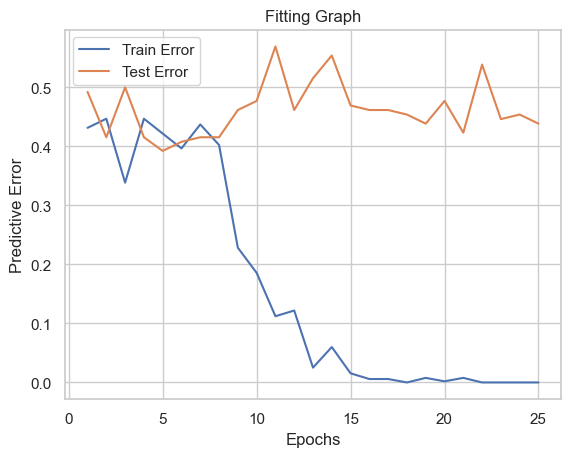

In [ ]:
generateFittingGraph(train_error, test_error, EPOCHS)

### Changing to Singular Class + Adjusting Hyperparameters

In [ ]:
MAX_LENGTH = 600
BATCH_SIZE = 32
EMBED_DIM = 256
NUM_HEAD = 4
NUM_LAYER = 4
NUM_OUTPUT = 1
EPOCHS = 25
LEARNING_RATE = 1e-5

train_dataset, test_dataset = train_test_split(data, test_size=0.2, shuffle=True, random_state=42)
train_dataloader, test_dataloader = createDataLoader(train_dataset, test_dataset, tokenizer, MAX_LENGTH, BATCH_SIZE)

model = UntrainedTransformerClassifier(vocab_size=tokenizer.vocab_size, 
                                       embed_dim= EMBED_DIM, 
                                       num_heads= NUM_HEAD, 
                                       num_layers=NUM_LAYER, 
                                       max_length=MAX_LENGTH,
                                       num_output=NUM_OUTPUT).to(device)

criterion = nn.BCEWithLogitsLoss()

optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

train_error = []
test_error = []

for epoch in range(EPOCHS):
    for xb, yb in train_dataloader:
        xb, yb = xb.to(device), yb.to(device)

        logits = model(xb).squeeze(1)
        loss = criterion(logits, yb)
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    trainErr = evaluate(model, train_dataloader, device)    
    testErr = evaluate(model, test_dataloader, device) 

    print(f"Epoch [{epoch+1}/{EPOCHS}], Loss: {loss.item():.4f}, Train Acc: {trainErr:.4f}, Test Acc: {testErr:.4f}")

    train_error.append(1-trainErr)
    test_error.append(1-testErr)

Epoch [1/25], Loss: 0.5976, Train Acc: 0.5416, Test Acc: 0.5615
Epoch [2/25], Loss: 0.6670, Train Acc: 0.5551, Test Acc: 0.5231
Epoch [3/25], Loss: 0.7291, Train Acc: 0.5725, Test Acc: 0.5000
Epoch [4/25], Loss: 0.5864, Train Acc: 0.5899, Test Acc: 0.5000
Epoch [5/25], Loss: 0.6268, Train Acc: 0.5977, Test Acc: 0.5308
Epoch [6/25], Loss: 0.7173, Train Acc: 0.6132, Test Acc: 0.5077
Epoch [7/25], Loss: 0.6264, Train Acc: 0.6151, Test Acc: 0.5077
Epoch [8/25], Loss: 0.6699, Train Acc: 0.6170, Test Acc: 0.5385
Epoch [9/25], Loss: 0.6005, Train Acc: 0.6422, Test Acc: 0.5077
Epoch [10/25], Loss: 0.6956, Train Acc: 0.6402, Test Acc: 0.5308
Epoch [11/25], Loss: 0.7775, Train Acc: 0.6692, Test Acc: 0.5077
Epoch [12/25], Loss: 0.6874, Train Acc: 0.6596, Test Acc: 0.5385
Epoch [13/25], Loss: 0.6563, Train Acc: 0.7041, Test Acc: 0.5000
Epoch [14/25], Loss: 0.5697, Train Acc: 0.6789, Test Acc: 0.5462
Epoch [15/25], Loss: 0.6167, Train Acc: 0.7157, Test Acc: 0.5231
Epoch [16/25], Loss: 0.6319, Train

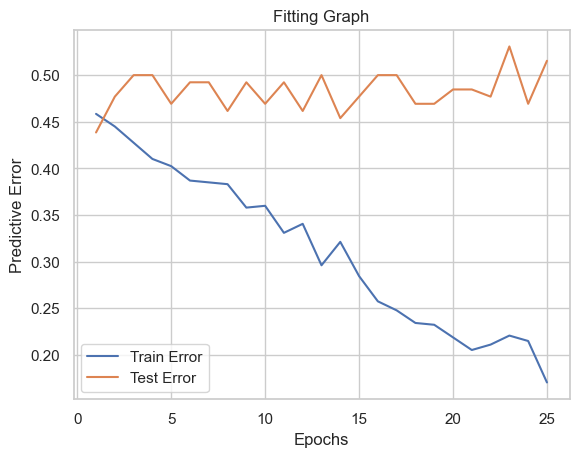

In [ ]:
generateFittingGraph(train_error, test_error, EPOCHS)

### Removing Specific Proper Words (remix, cramers lightning round)

In [34]:
def clean_headlines(text):
    words_to_remove = ['remix', 'cramers lightning round']

    pattern = r'\b(' + '|'.join(words_to_remove) + r')\b'
    cleaned = re.sub(pattern, '', text, flags=re.IGNORECASE)

    cleaned = re.sub(r'\s+', ' ', cleaned).strip()
    return cleaned

In [35]:
data_clean = data.copy()
data_clean['Headlines'] = data_clean['Headlines'].apply(clean_headlines)

In [ ]:
MAX_LENGTH = 600
BATCH_SIZE = 32
EMBED_DIM = 256
NUM_HEAD = 4
NUM_LAYER = 4
NUM_OUTPUT = 1
EPOCHS = 25
LEARNING_RATE = 1e-5

train_dataset, test_dataset = train_test_split(data, test_size=0.2, shuffle=True, random_state=42)
train_dataloader, test_dataloader = createDataLoader(train_dataset, test_dataset, tokenizer, MAX_LENGTH, BATCH_SIZE)

model = UntrainedTransformerClassifier(vocab_size=tokenizer.vocab_size, 
                                       embed_dim= EMBED_DIM, 
                                       num_heads= NUM_HEAD, 
                                       num_layers=NUM_LAYER, 
                                       max_length=MAX_LENGTH,
                                       num_output=NUM_OUTPUT).to(device)

criterion = nn.BCEWithLogitsLoss()

optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

train_error = []
test_error = []

for epoch in range(EPOCHS):
    for xb, yb in train_dataloader:
        xb, yb = xb.to(device), yb.to(device)

        logits = model(xb).squeeze(1)
        loss = criterion(logits, yb)
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    trainErr = evaluate(model, train_dataloader, device)    
    testErr = evaluate(model, test_dataloader, device) 

    print(f"Epoch [{epoch+1}/{EPOCHS}], Loss: {loss.item():.4f}, Train Acc: {trainErr:.4f}, Test Acc: {testErr:.4f}")

    train_error.append(1-trainErr)
    test_error.append(1-testErr)

Epoch [1/25], Loss: 0.6536, Train Acc: 0.5609, Test Acc: 0.5231
Epoch [2/25], Loss: 0.8111, Train Acc: 0.5493, Test Acc: 0.5769
Epoch [3/25], Loss: 0.7412, Train Acc: 0.5667, Test Acc: 0.5154
Epoch [4/25], Loss: 0.5832, Train Acc: 0.5938, Test Acc: 0.5462
Epoch [5/25], Loss: 0.6100, Train Acc: 0.5938, Test Acc: 0.5308
Epoch [6/25], Loss: 0.5949, Train Acc: 0.5957, Test Acc: 0.5385
Epoch [7/25], Loss: 0.8251, Train Acc: 0.6112, Test Acc: 0.5231
Epoch [8/25], Loss: 0.7631, Train Acc: 0.6286, Test Acc: 0.5077
Epoch [9/25], Loss: 0.8226, Train Acc: 0.6422, Test Acc: 0.5308
Epoch [10/25], Loss: 0.6388, Train Acc: 0.6615, Test Acc: 0.5308
Epoch [11/25], Loss: 0.6475, Train Acc: 0.6596, Test Acc: 0.5385
Epoch [12/25], Loss: 0.7654, Train Acc: 0.6867, Test Acc: 0.5308
Epoch [13/25], Loss: 0.7085, Train Acc: 0.6925, Test Acc: 0.5308
Epoch [14/25], Loss: 0.7192, Train Acc: 0.7195, Test Acc: 0.5154
Epoch [15/25], Loss: 0.5440, Train Acc: 0.7099, Test Acc: 0.5385
Epoch [16/25], Loss: 0.6564, Train

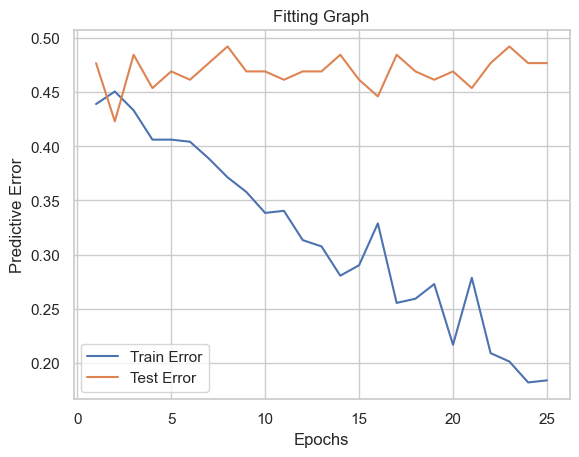

In [ ]:
generateFittingGraph(train_error, test_error, EPOCHS)

### Removing Stop Words (Best Model)

In [36]:
data_clean['Headlines'] = data_clean['Headlines'].apply(word_tokenize)
stop_words = set(stopwords.words('english'))
data_clean['Headlines'] = data_clean['Headlines'].apply(lambda x: [word for word in x if word not in stop_words])

i=0
for headline in data_clean['Headlines']:
    new_headline = ' '.join(headline)
    data_clean.loc[i, 'Headlines'] = new_headline
    i+=1

In [ ]:
MAX_LENGTH = 600
BATCH_SIZE = 32
EMBED_DIM = 256
NUM_HEAD = 4
NUM_LAYER = 4
NUM_OUTPUT = 1
EPOCHS = 25
LEARNING_RATE = 1e-5

train_dataset, test_dataset = train_test_split(data, test_size=0.2, shuffle=True, random_state=42)
train_dataloader, test_dataloader = createDataLoader(train_dataset, test_dataset, tokenizer, MAX_LENGTH, BATCH_SIZE)

model = UntrainedTransformerClassifier(vocab_size=tokenizer.vocab_size, 
                                       embed_dim= EMBED_DIM, 
                                       num_heads= NUM_HEAD, 
                                       num_layers=NUM_LAYER, 
                                       max_length=MAX_LENGTH,
                                       num_output=NUM_OUTPUT).to(device)

criterion = nn.BCEWithLogitsLoss()

optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

train_error = []
test_error = []

for epoch in range(EPOCHS):
    for xb, yb in train_dataloader:
        xb, yb = xb.to(device), yb.to(device)

        logits = model(xb).squeeze(1)
        loss = criterion(logits, yb)
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    trainErr = evaluate(model, train_dataloader, device)    
    testErr = evaluate(model, test_dataloader, device) 

    print(f"Epoch [{epoch+1}/{EPOCHS}], Loss: {loss.item():.4f}, Train Acc: {trainErr:.4f}, Test Acc: {testErr:.4f}")

    train_error.append(1-trainErr)
    test_error.append(1-testErr)

Epoch [1/25], Loss: 0.7229, Train Acc: 0.5648, Test Acc: 0.5077
Epoch [2/25], Loss: 0.8445, Train Acc: 0.5532, Test Acc: 0.5923
Epoch [3/25], Loss: 0.7327, Train Acc: 0.5609, Test Acc: 0.5154
Epoch [4/25], Loss: 0.6951, Train Acc: 0.6015, Test Acc: 0.5154
Epoch [5/25], Loss: 0.6995, Train Acc: 0.6054, Test Acc: 0.5308
Epoch [6/25], Loss: 0.7201, Train Acc: 0.5996, Test Acc: 0.5231
Epoch [7/25], Loss: 0.7392, Train Acc: 0.6248, Test Acc: 0.5231
Epoch [8/25], Loss: 0.6499, Train Acc: 0.6267, Test Acc: 0.5154
Epoch [9/25], Loss: 0.6847, Train Acc: 0.6441, Test Acc: 0.5231
Epoch [10/25], Loss: 0.7235, Train Acc: 0.6480, Test Acc: 0.5308
Epoch [11/25], Loss: 0.7258, Train Acc: 0.6538, Test Acc: 0.5308
Epoch [12/25], Loss: 0.4773, Train Acc: 0.6480, Test Acc: 0.5308
Epoch [13/25], Loss: 0.6000, Train Acc: 0.6557, Test Acc: 0.5308
Epoch [14/25], Loss: 0.6935, Train Acc: 0.6770, Test Acc: 0.5308
Epoch [15/25], Loss: 0.6432, Train Acc: 0.6847, Test Acc: 0.5308
Epoch [16/25], Loss: 0.6397, Train

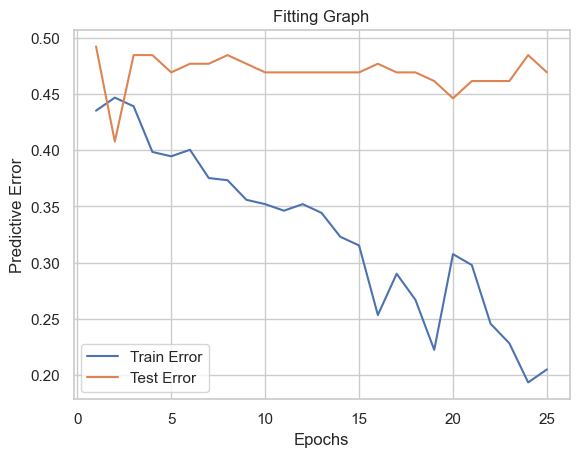

In [38]:
generateFittingGraph(train_error, test_error, EPOCHS)

### Increasing Number of Heads with LR Decay

In [ ]:
MAX_LENGTH = 600
BATCH_SIZE = 32
EMBED_DIM = 256
NUM_HEAD = 16
NUM_LAYER = 4
NUM_OUTPUT = 1
EPOCHS = 25
LEARNING_RATE = 1e-5

train_dataset, test_dataset = train_test_split(data, test_size=0.2, shuffle=True, random_state=42)
train_dataloader, test_dataloader = createDataLoader(train_dataset, test_dataset, tokenizer, MAX_LENGTH, BATCH_SIZE)

model = UntrainedTransformerClassifier(vocab_size=tokenizer.vocab_size, 
                                       embed_dim= EMBED_DIM, 
                                       num_heads= NUM_HEAD, 
                                       num_layers=NUM_LAYER, 
                                       max_length=MAX_LENGTH,
                                       num_output=NUM_OUTPUT).to(device)

criterion = nn.BCEWithLogitsLoss()

optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
scheduler = ExponentialLR(optimizer, gamma=0.9)

train_error = []
test_error = []

for epoch in range(EPOCHS):
    for xb, yb in train_dataloader:
        xb, yb = xb.to(device), yb.to(device)

        logits = model(xb).squeeze(1)
        loss = criterion(logits, yb)
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    scheduler.step()
    trainErr = evaluate(model, train_dataloader, device)    
    testErr = evaluate(model, test_dataloader, device) 

    print(f"Epoch [{epoch+1}/{EPOCHS}], Loss: {loss.item():.4f}, Train Acc: {trainErr:.4f}, Test Acc: {testErr:.4f}")

    train_error.append(1-trainErr)
    test_error.append(1-testErr)

Epoch [1/25], Loss: 0.5685, Train Acc: 0.4526, Test Acc: 0.3846
Epoch [2/25], Loss: 0.7701, Train Acc: 0.5513, Test Acc: 0.5769
Epoch [3/25], Loss: 0.7504, Train Acc: 0.5280, Test Acc: 0.5154
Epoch [4/25], Loss: 0.6152, Train Acc: 0.5261, Test Acc: 0.5154
Epoch [5/25], Loss: 0.7244, Train Acc: 0.5435, Test Acc: 0.5154
Epoch [6/25], Loss: 0.7350, Train Acc: 0.5319, Test Acc: 0.5000
Epoch [7/25], Loss: 0.6762, Train Acc: 0.5222, Test Acc: 0.4615
Epoch [8/25], Loss: 0.7664, Train Acc: 0.5474, Test Acc: 0.5154
Epoch [9/25], Loss: 0.6085, Train Acc: 0.5455, Test Acc: 0.5000
Epoch [10/25], Loss: 0.6565, Train Acc: 0.5590, Test Acc: 0.5385
Epoch [11/25], Loss: 0.6903, Train Acc: 0.5532, Test Acc: 0.5154
Epoch [12/25], Loss: 0.6039, Train Acc: 0.5706, Test Acc: 0.5231
Epoch [13/25], Loss: 0.7379, Train Acc: 0.5667, Test Acc: 0.5154
Epoch [14/25], Loss: 0.7055, Train Acc: 0.5706, Test Acc: 0.5308
Epoch [15/25], Loss: 0.6815, Train Acc: 0.5706, Test Acc: 0.5385
Epoch [16/25], Loss: 0.6845, Train

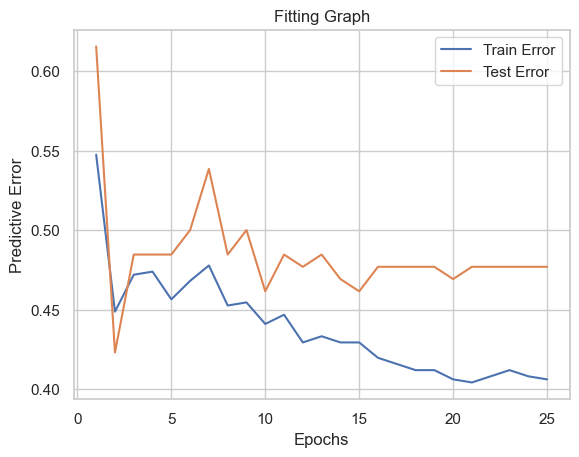

In [ ]:
generateFittingGraph(train_error, test_error, EPOCHS)

### Increasing number of heads without LR Decay

In [ ]:
MAX_LENGTH = 600
BATCH_SIZE = 32
EMBED_DIM = 256
NUM_HEAD = 16
NUM_LAYER = 4
NUM_OUTPUT = 1
EPOCHS = 25
LEARNING_RATE = 1e-5

train_dataset, test_dataset = train_test_split(data, test_size=0.2, shuffle=True, random_state=42)
train_dataloader, test_dataloader = createDataLoader(train_dataset, test_dataset, tokenizer, MAX_LENGTH, BATCH_SIZE)

model = UntrainedTransformerClassifier(vocab_size=tokenizer.vocab_size, 
                                       embed_dim= EMBED_DIM, 
                                       num_heads= NUM_HEAD, 
                                       num_layers=NUM_LAYER, 
                                       max_length=MAX_LENGTH,
                                       num_output=NUM_OUTPUT).to(device)

criterion = nn.BCEWithLogitsLoss()

optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

train_error = []
test_error = []

for epoch in range(EPOCHS):
    for xb, yb in train_dataloader:
        xb, yb = xb.to(device), yb.to(device)

        logits = model(xb).squeeze(1)
        loss = criterion(logits, yb)
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    trainErr = evaluate(model, train_dataloader, device)    
    testErr = evaluate(model, test_dataloader, device) 

    print(f"Epoch [{epoch+1}/{EPOCHS}], Loss: {loss.item():.4f}, Train Acc: {trainErr:.4f}, Test Acc: {testErr:.4f}")

    train_error.append(1-trainErr)
    test_error.append(1-testErr)

Epoch [1/25], Loss: 0.4768, Train Acc: 0.5474, Test Acc: 0.5923
Epoch [2/25], Loss: 0.6846, Train Acc: 0.5338, Test Acc: 0.4692
Epoch [3/25], Loss: 0.5884, Train Acc: 0.5687, Test Acc: 0.4923
Epoch [4/25], Loss: 0.6728, Train Acc: 0.5513, Test Acc: 0.5538
Epoch [5/25], Loss: 0.6122, Train Acc: 0.5609, Test Acc: 0.5462
Epoch [6/25], Loss: 0.6698, Train Acc: 0.5629, Test Acc: 0.5462
Epoch [7/25], Loss: 0.6003, Train Acc: 0.5725, Test Acc: 0.5308
Epoch [8/25], Loss: 0.7023, Train Acc: 0.5706, Test Acc: 0.5385
Epoch [9/25], Loss: 0.6091, Train Acc: 0.5687, Test Acc: 0.5538
Epoch [10/25], Loss: 0.7217, Train Acc: 0.5919, Test Acc: 0.5385
Epoch [11/25], Loss: 0.6499, Train Acc: 0.6112, Test Acc: 0.5462
Epoch [12/25], Loss: 0.6504, Train Acc: 0.6170, Test Acc: 0.5462
Epoch [13/25], Loss: 0.6115, Train Acc: 0.5803, Test Acc: 0.5538
Epoch [14/25], Loss: 0.6101, Train Acc: 0.6383, Test Acc: 0.5385
Epoch [15/25], Loss: 0.7307, Train Acc: 0.6499, Test Acc: 0.5385
Epoch [16/25], Loss: 0.6045, Train

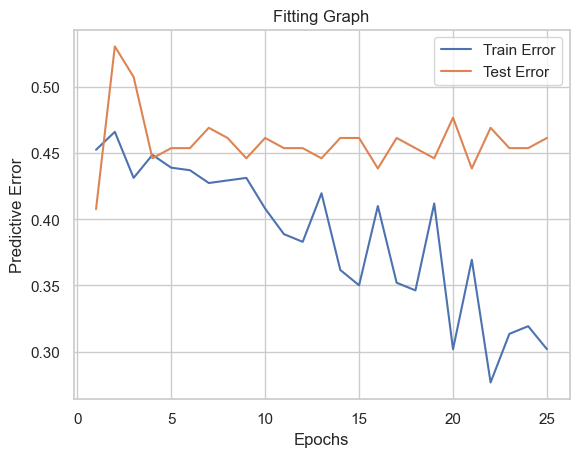

In [ ]:
generateFittingGraph(train_error, test_error, EPOCHS)

### Predictive Evaluation of the Best Iteration

In [ ]:
model.eval()
correct = 0
total_samples = 0
FP = 0
FN = 0
confusion_matrix = BinaryConfusionMatrix().to(device)

with torch.no_grad():
    for X, Y in test_dataloader:
        input_ids = X.to(device)
        labels = Y.to(device)

        logits = model(input_ids)
        outputs = torch.sigmoid(logits).squeeze(1)


        preds = (outputs >= 0.5).float()
        correct += (preds == labels).sum().item()
        conf_matrix = confusion_matrix(labels, preds)
        FP += conf_matrix[0,1].item()
        FN += conf_matrix[1,0].item()
        total_samples += labels.size(0)
print(f"Correct: {correct}, False Positive: {FP}, False Negative: {FN}, Total Samples: {total_samples}")


Correct: 69, False Positive: 16, False Negative: 45, Total Samples: 130
